In [1]:
# Data Preprocessing for Yelp Reviews Sentiment Analysis

import sys
import os
# Add the src directory to path for importing modules
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from nltk.tokenize import word_tokenize
import pickle
import logging

# Import our custom modules
from src.data.data_loader import YelpDataLoader
from src.data.preprocessor import TextPreprocessor, LSTMPreprocessor, DistilBERTPreprocessor
from transformers import DistilBertTokenizer
from src.config import (
    PROCESSED_TRAIN_PATH, PROCESSED_TEST_PATH, 
    EMBEDDINGS_DIR, LSTM_CONFIG, DISTILBERT_CONFIG
)

2025-04-09 20:45:03,068 - src.data.preprocessor - INFO - Downloading necessary NLTK resources...
[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Enable progress bars for DataFrames
tqdm.pandas()

# Set up plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Create directories if they don't exist
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

In [3]:
# 1. Load the data
print("Loading processed data...")
data_loader = YelpDataLoader()
train_df, test_df = data_loader.load_processed_data()

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Show distribution of sentiment labels
print("\nSentiment distribution in train set:")
print(train_df['sentiment'].value_counts().sort_index())

print("\nSentiment distribution in test set:")
print(test_df['sentiment'].value_counts().sort_index())

2025-04-09 20:45:03,186 - src.data.data_loader - INFO - Loading processed data from local files...


Loading processed data...
Train set shape: (650000, 5)
Test set shape: (50000, 3)

Sentiment distribution in train set:
sentiment
0    260000
1    130000
2    260000
Name: count, dtype: int64

Sentiment distribution in test set:
sentiment
0    20000
1    10000
2    20000
Name: count, dtype: int64


In [4]:
# 2. Basic text preprocessing and analysis
print("\n--- Basic Text Preprocessing Analysis ---")

# Initialize basic preprocessor for analysis
basic_preprocessor = TextPreprocessor(remove_stopwords=True, lemmatize=True)

# Sample a subset for analysis
sample_size = 10000  # Using a subset for faster analysis
train_sample = train_df.sample(sample_size, random_state=42)

# Apply basic preprocessing to a sample
print("Preprocessing a sample of reviews...")
train_sample['cleaned_tokens'] = train_sample['text'].progress_apply(basic_preprocessor.tokenize)

# Calculate statistics
train_sample['token_count'] = train_sample['cleaned_tokens'].apply(len)

# Print statistics about token counts
print("\nToken count statistics after preprocessing:")
print(train_sample['token_count'].describe())

# Show example of preprocessed text
print("\nExample of preprocessed text:")
example_idx = 0
print(f"Original: {train_sample.iloc[example_idx]['text'][:200]}...")
print(f"Tokenized: {train_sample.iloc[example_idx]['cleaned_tokens'][:30]}...")



--- Basic Text Preprocessing Analysis ---
Preprocessing a sample of reviews...


100%|██████████| 10000/10000 [00:05<00:00, 1932.59it/s]



Token count statistics after preprocessing:
count    10000.000000
mean        68.073100
std         62.379157
min          1.000000
25%         27.000000
50%         50.000000
75%         88.000000
max        483.000000
Name: token_count, dtype: float64

Example of preprocessed text:
Original: First of all i'm not a big fan of buffet, i tried it because we got a $50 credit for staying here at Monte Carlo in Las Vegas and my friend wanted it so I gave it a chance. Decent taste and There wasn...
Tokenized: ['first', 'im', 'big', 'fan', 'buffet', 'tried', 'got', '50', 'credit', 'staying', 'monte', 'carlo', 'la', 'vega', 'friend', 'wanted', 'gave', 'chance', 'decent', 'taste', 'wasnt', 'enough', 'variety', 'food', 'service', 'wasnt', 'great', 'either', 'still', 'doesnt']...


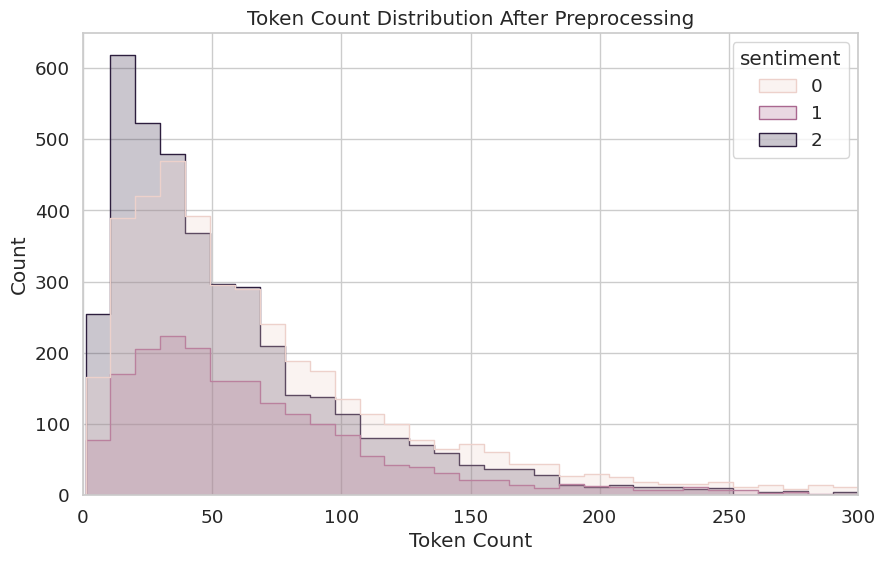

In [5]:
# Plot distribution of token counts
plt.figure(figsize=(10, 6))
sns.histplot(data=train_sample, x='token_count', bins=50, hue='sentiment', element='step')
plt.title('Token Count Distribution After Preprocessing')
plt.xlabel('Token Count')
plt.ylabel('Count')
plt.xlim(0, 300)  # Focus on main distribution
plt.show()

In [6]:
# 3. LSTM-specific preprocessing
print("\n--- LSTM Preprocessing ---")

# Initialize LSTM preprocessor
lstm_preprocessor = LSTMPreprocessor(
    max_vocab_size=LSTM_CONFIG['max_vocab_size'],
    max_sequence_length=LSTM_CONFIG['max_sequence_length'],
    remove_stopwords=True, 
    lemmatize=True
)

# Process a small sample for demonstration
sample_size = 1000  # Small sample for demonstration
train_mini = train_df.sample(sample_size, random_state=42)

print("Tokenizing sample texts for LSTM...")
tokenized_texts = [lstm_preprocessor.tokenize(text) for text in tqdm(train_mini['text'])]

print("Building vocabulary from sample...")
word_to_idx = lstm_preprocessor.fit(tokenized_texts)

print(f"Vocabulary size: {lstm_preprocessor.vocab_size}")
print(f"First 10 words in vocabulary: {list(word_to_idx.items())[:10]}")

# Convert tokens to sequences
print("Converting tokens to sequences...")
sequences = lstm_preprocessor.texts_to_sequences(tokenized_texts)

# Pad sequences
print("Padding sequences...")
padded_sequences = lstm_preprocessor.pad_sequences(sequences)

print(f"Shape of padded sequences: {padded_sequences.shape}")



--- LSTM Preprocessing ---
Tokenizing sample texts for LSTM...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2177.09it/s]
2025-04-09 20:45:10,653 - src.data.preprocessor - INFO - Building vocabulary...
2025-04-09 20:45:10,664 - src.data.preprocessor - INFO - Vocabulary built with 10716 words


Building vocabulary from sample...
Vocabulary size: 10716
First 10 words in vocabulary: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('and', 3), ('to', 4), ('wa', 5), ('it', 6), ('of', 7), ('for', 8), ('in', 9)]
Converting tokens to sequences...
Padding sequences...
Shape of padded sequences: (1000, 512)


In [7]:
# 5. DistilBERT-specific preprocessing
print("\n--- DistilBERT Preprocessing ---")

# Initialize tokenizer
print(
    f"Initializing DistilBERT tokenizer: {DISTILBERT_CONFIG['pretrained_model_name']}"
)
tokenizer = DistilBertTokenizer.from_pretrained(
    DISTILBERT_CONFIG["pretrained_model_name"]
)

# Initialize DistilBERT preprocessor
distilbert_preprocessor = DistilBERTPreprocessor(tokenizer,
    pretrained_model_name=DISTILBERT_CONFIG['pretrained_model_name'],
    max_sequence_length=DISTILBERT_CONFIG['max_sequence_length']
)

# Process a small sample for demonstration
sample_size = 5  # Very small for demonstration
train_mini = train_df.sample(sample_size, random_state=42)

print("Preprocessing sample texts for DistilBERT...")
# Preprocess the sample texts
processed = distilbert_preprocessor.preprocess_for_distilbert(
    texts=train_mini['text'].tolist(),
    padding=True,
    truncation=True
)

# Extract processed components
input_ids = processed["input_ids"]
attention_masks = processed["attention_mask"]

# Print processing results
print(f"\nProcessed outputs shape:")
print(f"Input IDs tensor shape: {input_ids.shape}")
print(f"Attention masks tensor shape: {attention_masks.shape}")

# Show input details
print("\nExample of processed input:")
sample_idx = 0
print(f"Original text:\n{train_mini.iloc[sample_idx]['text']}\n")
print(f"Tokenized input IDs:\n{input_ids[sample_idx]}")
print(f"Attention mask:\n{attention_masks[sample_idx]}")

# Additional analysis
sequence_lengths = attention_masks.sum(dim=1).tolist()
print("\nSequence length distribution:")
print(pd.Series(sequence_lengths).describe())

# Save processed sample for demonstration (optional)
torch.save({
    'input_ids': input_ids,
    'attention_masks': attention_masks,
    'labels': torch.tensor(train_mini['sentiment'].values)
}, os.path.join(EMBEDDINGS_DIR, 'distilbert_processed_sample.pt'))

logger.info("DistilBERT preprocessing completed successfully")


--- DistilBERT Preprocessing ---
Initializing DistilBERT tokenizer: distilbert-base-uncased


2025-04-09 20:45:11,918 - src.data.preprocessor - INFO - Initialized DistilBERT preprocessor with distilbert-base-uncased tokenizer
2025-04-09 20:45:11,950 - root - INFO - DistilBERT preprocessing completed successfully


Preprocessing sample texts for DistilBERT...

Processed outputs shape:
Input IDs tensor shape: torch.Size([5, 512])
Attention masks tensor shape: torch.Size([5, 512])

Example of processed input:
Original text:
First of all i'm not a big fan of buffet, i tried it because we got a $50 credit for staying here at Monte Carlo in Las Vegas and my friend wanted it so I gave it a chance. Decent taste and There wasn't enough variety of food, service wasn't that great either. so it still doesn't change my mind about buffet.

Tokenized input IDs:
tensor([  101,  2034,  1997,  2035,  1045,  1005,  1049,  2025,  1037,  2502,
         5470,  1997, 28305,  1010,  1045,  2699,  2009,  2138,  2057,  2288,
         1037,  1002,  2753,  4923,  2005,  6595,  2182,  2012, 10125,  9758,
         1999,  5869,  7136,  1998,  2026,  2767,  2359,  2009,  2061,  1045,
         2435,  2009,  1037,  3382,  1012, 11519,  5510,  1998,  2045,  2347,
         1005,  1056,  2438,  3528,  1997,  2833,  1010,  2326,  23